# Data Cleaning

In [2]:
import sys, os
sys.path.append('../')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.cleaning import cleaning_pipeline
import warnings
warnings.filterwarnings("ignore")

# Data Ingestion

In [3]:
df = pd.read_csv("./Data/teste_indicium_precificacao.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (48894, 16)


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# General Look at the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [5]:
df.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Observations:
- The dataset contains missing values in four columns: `nome`, `host_name`, `ultima_review`, `reviews_por_mes`. The last two have the same amount of NaN values
- There are no duplicated rows
- It contains two Id columns, with `id` being the identifier of the ad and `host_id` being the identifier of who hosted the ad 
- The `price` column is the target, since the objective is to predict rent prices per night
- All numerical columns appear to be heavily skewed, with outliers. The column `minimo_noites` has a maximum value of 1250, implying that the host should rent the place for this number of nights at a minimum

### Impact:
- Missing data in the columns `ultima_review` and `reviews_por_mes` should be handled
- Both id columns, together with `host_name` must be dropped since they have no value
- All numerical columns should be investigated to see if there are outliers that are so extreme, that the only explanation for them to be here is because of a typo or something of this nature

# Missing Data

In [9]:
missing_data = (df["ultima_review"].isna()) | (df["reviews_por_mes"].isna())
df[missing_data].shape

(10052, 16)

In [10]:
filter_missing_df = df[missing_data]
filter_missing_df["numero_de_reviews"].value_counts()

numero_de_reviews
0    10052
Name: count, dtype: int64

### Observations:
- Everytime that `ultima_review` is a NaN value, so is `reviews_por_mes`
- `numero_de_reviews` confirms that there's no error in the dataset. Every time there's a missing value in those columns, `numero_de_reviews` is 0 

### Impact:
- Since `ultima_review` is in date format, and it's impossible to set a date for a review that never happened, this column will be dropped
- All missing values of `reviews_por_mes` will be replaced by 0, since `numero_de_reviews` is also 0 on every occasion

# Outilers

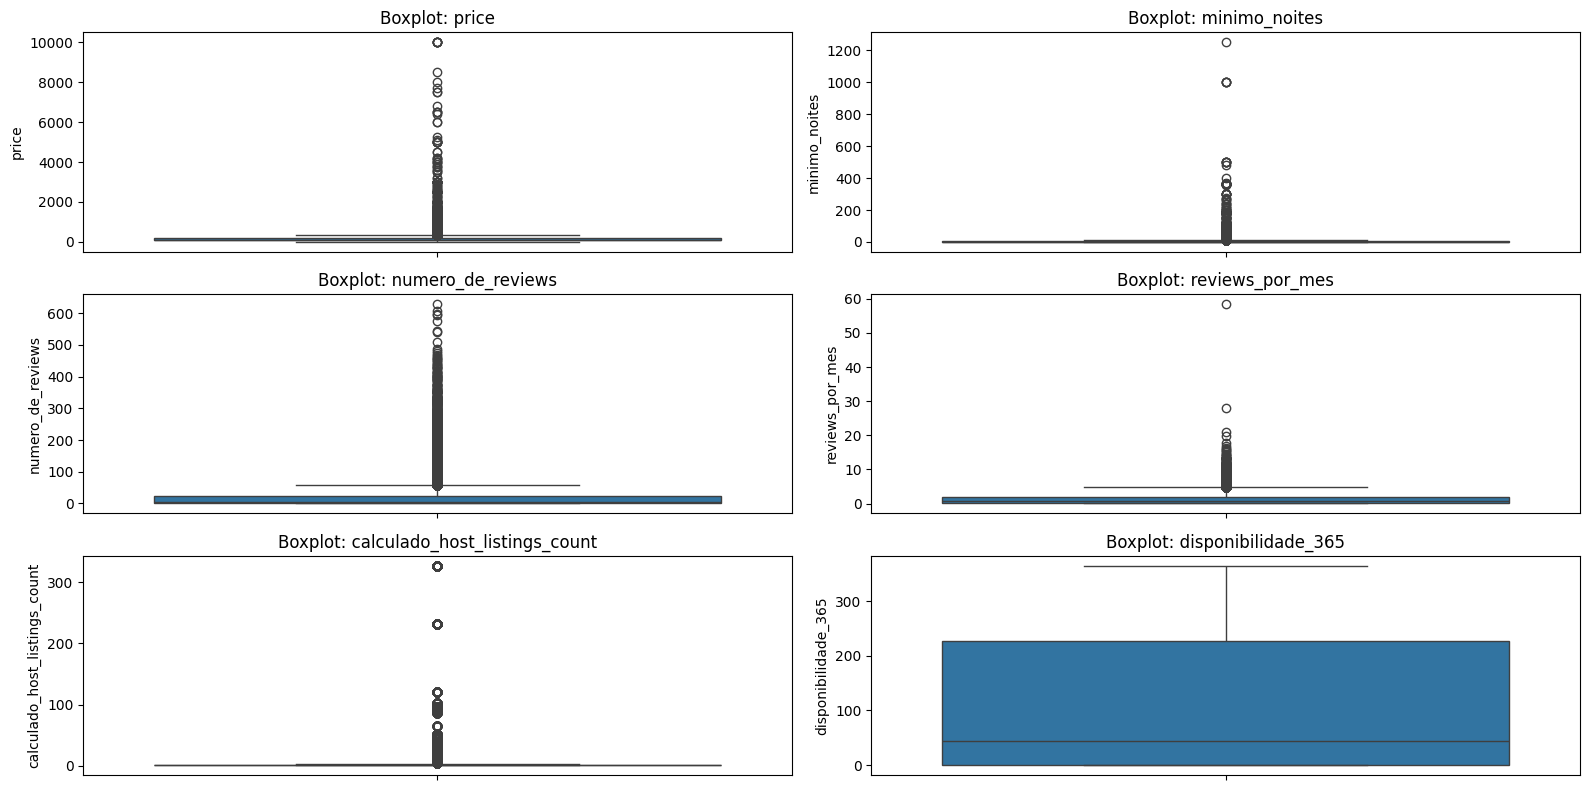

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(16, 8))
ax = ax.ravel()
columns = ["id", "host_id", "latitude", "longitude"]
for i, col in enumerate(df.drop(columns=columns).select_dtypes("number")):
    sns.boxplot(y=df[col], ax=ax[i])
    ax[i].set_title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

In [12]:
df[(df["price"] > 1000)].shape[0]

239

In [13]:
df[df["minimo_noites"] > 365].shape[0]

14

### Observations:
- Only `price` and `minimo_noites` showed a strange behaviour
- `minimo_noites` has ads that are saying that the minimal time to stay is more than 365, which is strange since 365 is the max number of days that the listing is available for booking
- Given that `price` is the amount to be paid by night, and not a monthly value, it's too far fetched that a property has a value of over 1000 dollars a night, unless it's something very unusual like a penthouse or that the listing is taking place when theres a big event in town

### Impact:
- All ads with `minimo_noites` above 365 will be dropped
- All ads with `price` above 1000 will be dropped

# Data Cleaning Pipeline

### Based on the analysis in this notebook, the following data cleaning steps will be taken:
- Remove the columns: `id`, `host_id`, `host_name` and `ultima_review`. The column `nome` will be used to determine if there's a pattern in the text for high-end places and its missing data will be filed with "No name"
- Fill all NaN values of `reviews_por_mes` with 0
- Remove all rows where `minimo_noites` is above 365 or where `price` is above 1000

In [6]:
columns_to_drop = ['id', 'host_id', 'host_name', 'ultima_review']
cleaning_pipeline(df, columns_to_drop, "Data", "clean_teste_indicium_precificacao")